**Table of contents**<a id='toc0_'></a>    
- 1. [EXPLORATORY **SQL** DATA ANALYSIS OF SQLITE AIRLINE FLIGHTS INFORMATION](#toc1_)    
  - 1.1. [DATABASE SCHEMA](#toc1_1_)    
  - 1.2. [What are the fare conditions, the number of bookings and their price?](#toc1_2_)    
  - 1.3. [What are the priciest Business tickets for the longest flights?](#toc1_3_)    
  - 1.4. [What are the cheapest Economy tickets for the longest flights?](#toc1_4_)    
  - 1.5. [What are distances travelled by the longest flights?](#toc1_5_)    
  - 1.6. [Display routes of longest flights](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[EXPLORATORY **SQL** DATA ANALYSIS OF SQLITE AIRLINE FLIGHTS INFORMATION](#toc0_)

In [1]:
import os 
import sqlalchemy as sql
from sqlalchemy_schemadisplay import create_schema_graph
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import haversine as hs #amazing library for computing geolocation distances, does the same as sklearn.metrics
# this will prevet column breaks when printing dataframes
pd.set_option('display.width', 1000)

In [2]:
base_dir = os.path.abspath("")
filename = "travel.sqlite"
engine = sql.create_engine("sqlite:///"+os.path.join(base_dir,"dataset",filename))

In [3]:
# Connect to engine
connection = engine.connect()

In [4]:
# Create inspector and list tables
inspector = sql.inspect(engine)
table_names = inspector.get_table_names()
print("TABLES:")
print("\n".join(table_names))

TABLES:
aircrafts_data
airports_data
boarding_passes
bookings
flights
seats
ticket_flights
tickets


In [ ]:
# Get metadata to generate schema
metadata = sql.MetaData()
metadata.reflect(engine)

### 1.1. <a id='toc1_1_'></a>[DATABASE SCHEMA](#toc0_)

In [ ]:
graph = create_schema_graph(
    engine=engine,
    metadata=metadata,
    show_datatypes=True,
    show_indexes=True, # ditto for indexes
    rankdir='TB', # From top to bottom
    concentrate=False, # Don't try to join the relation lines together
)
graph.set_size('"20,4!"')
graph.write_png(filename.replace(".sqlite","")+"_schema.png")

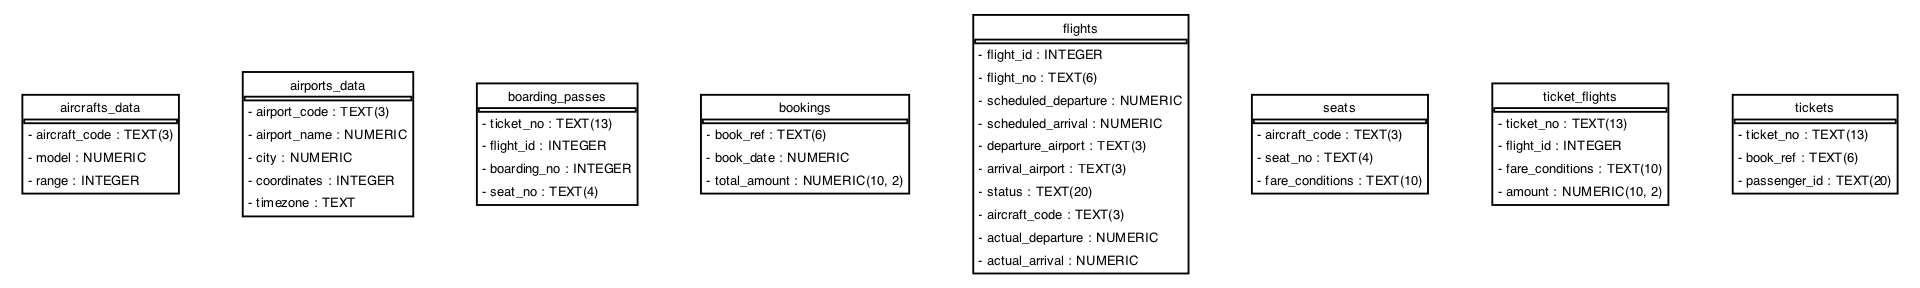

### 1.2. <a id='toc1_2_'></a>[What are the fare conditions, the number of bookings and their price?](#toc0_)

In [ ]:
rs = connection.execute(
    sql.text(
        '''
        WITH table_a AS (
            SELECT DISTINCT flights.flight_no AS 'flight', flights.departure_airport,
            flights.arrival_airport, CAST(ticket_flights.amount AS INT) AS 'price', 
            ticket_flights.fare_conditions AS 'fare',
            ticket_flights.ticket_no AS 'ticket'
            FROM flights 
            JOIN ticket_flights 
            ON flights.flight_id = ticket_flights.flight_id
        )
        SELECT fare,
        COUNT(ticket) AS 'no_of_tickets',
        COUNT(ticket) * 100.0 / SUM(COUNT(ticket)) OVER () AS 'percentage',
        ROUND(AVG("price")) as 'average_price(RUB)',
        MIN("price") as 'lowest_price(RUB)',
        MAX("price") as 'highest_price(RUB)',
        SUM("price") as 'total_purchased(RUB)'
        FROM table_a
        GROUP BY fare
        '''
        )
    )
price_biz_list=pd.DataFrame(rs.fetchall())
price_biz_list.columns=rs.keys()
print(price_biz_list.head())

       fare  no_of_tickets  percentage  average_price(RUB)  lowest_price(RUB)  highest_price(RUB)  total_purchased(RUB)
0  Business         107642   10.293519             51143.0               9100              203300            5505179600
1   Comfort          17291    1.653492             32741.0              19900               47600             566116900
2   Economy         920793   88.052989             15960.0               3000               74500           14695684400


### 1.3. <a id='toc1_3_'></a>[What are the priciest Business tickets for the longest flights?](#toc0_)

In [ ]:
rs = connection.execute(
    sql.text(
        '''
        WITH table_a AS (
            SELECT flights.flight_no AS 'flight', 
            flights.flight_id AS 'flight_id',
            flights.departure_airport, flights.arrival_airport, 
            MAX(CAST(ticket_flights.amount AS INT)) AS 'price(RUB)', 
            ticket_flights.fare_conditions AS 'fare',
            STRFTIME("%F %T", SUBSTR(flights.actual_departure,1,LENGTH(flights.actual_departure)-3)) AS 'actual_departure',
            STRFTIME('%F %T', SUBSTR(flights.actual_arrival,1,LENGTH(flights.actual_arrival)-3)) AS 'actual_arrival'
            FROM flights JOIN ticket_flights ON flights.flight_id = ticket_flights.flight_id
            WHERE fare='Business' AND 'actual_arrival' IS NOT NULL
            GROUP BY flights.flight_id
        ),
        table_b AS (
            SELECT flights.flight_no AS 'flight', 
            flights.flight_id AS 'flight_id',
            TIME(SUBSTR(TIMEDIFF(table_a.actual_arrival,table_a.actual_departure),13)) AS 'duration'
            FROM flights JOIN table_a ON flights.flight_id = table_a.flight_id
        )
        SELECT table_a.flight_id AS flight_id, table_a.flight AS flight, 
            departure_airport, arrival_airport, 
            MAX(duration) as "duration", 
            fare, "price(RUB)"
        FROM table_a JOIN table_b ON table_a.flight_id = table_b.flight_id
        WHERE duration IS NOT NULL
        GROUP BY table_a.flight
        ORDER BY duration DESC LIMIT 15
        '''
        )
    )
price_biz_list=pd.DataFrame(rs.fetchall())
price_biz_list.columns=rs.keys()
print(price_biz_list)

    flight_id  flight departure_airport arrival_airport  duration      fare  price(RUB)
0        1274  PG0168               DME             UUS  09:01:00  Business      199800
1        6011  PG0703               SVO             UUS  08:59:00  Business      199300
2       18080  PG0704               UUS             SVO  08:57:00  Business      199300
3       18005  PG0169               UUS             DME  08:57:00  Business      199800
4        1313  PG0144               DME             PKC  08:57:00  Business      203300
5       18243  PG0145               PKC             DME  08:56:00  Business      203300
6       19918  PG0108               GDX             MRV  08:56:00  Business      201300
7       20247  PG0109               MRV             GDX  08:49:00  Business      201300
8        4199  PG0200               VKO             VVO  08:37:00  Business      193100
9       26598  PG0201               VVO             VKO  08:34:00  Business      193100
10       6492  PG0255           

### 1.4. <a id='toc1_4_'></a>[What are the cheapest Economy tickets for the longest flights?](#toc0_)

In [ ]:
rs = connection.execute(
    sql.text(
        '''
        WITH table_a AS (
            SELECT flights.flight_no AS 'flight', 
            flights.flight_id AS 'flight_id',
            flights.departure_airport, flights.arrival_airport, 
            MIN(CAST(ticket_flights.amount AS INT)) AS 'price(RUB)', 
            ticket_flights.fare_conditions AS 'fare',
            STRFTIME('%F %T', SUBSTR(flights.actual_departure,1,LENGTH(flights.actual_departure)-3)) AS 'actual_departure',
            STRFTIME('%F %T', SUBSTR(flights.actual_arrival,1,LENGTH(flights.actual_arrival)-3)) AS 'actual_arrival'  
            FROM flights JOIN ticket_flights ON flights.flight_id = ticket_flights.flight_id
            WHERE fare='Economy' AND 'actual_arrival' IS NOT NULL
            GROUP BY flights.flight_id
        ),
        table_b AS (
            SELECT flights.flight_no AS 'flight', 
            flights.flight_id AS 'flight_id',
            TIME(SUBSTR(TIMEDIFF(table_a.actual_arrival,table_a.actual_departure),13)) AS 'duration'
            FROM flights JOIN table_a ON flights.flight_id = table_a.flight_id
        )
        SELECT table_a.flight_id AS flight_id, table_a.flight AS flight, 
            departure_airport, arrival_airport, 
            MAX(duration) as "duration", 
            fare, "price(RUB)"
        FROM table_a JOIN table_b ON table_a.flight_id = table_b.flight_id
        WHERE duration IS NOT NULL
        GROUP BY table_a.flight
        ORDER BY duration DESC LIMIT 15
        '''
        )
    )
price_econ_list=pd.DataFrame(rs.fetchall())
price_econ_list.columns=rs.keys()
print(price_econ_list)

    flight_id  flight departure_airport arrival_airport  duration     fare  price(RUB)
0        1274  PG0168               DME             UUS  09:01:00  Economy       66600
1        6011  PG0703               SVO             UUS  08:59:00  Economy       66400
2       18080  PG0704               UUS             SVO  08:57:00  Economy       66400
3       18005  PG0169               UUS             DME  08:57:00  Economy       66600
4        1313  PG0144               DME             PKC  08:57:00  Economy       67800
5       18243  PG0145               PKC             DME  08:56:00  Economy       67800
6       19918  PG0108               GDX             MRV  08:56:00  Economy       67100
7       20247  PG0109               MRV             GDX  08:49:00  Economy       67100
8        4199  PG0200               VKO             VVO  08:37:00  Economy       64400
9       26598  PG0201               VVO             VKO  08:34:00  Economy       64400
10       6492  PG0255               SVO    

### 1.5. <a id='toc1_5_'></a>[What are distances travelled by the longest flights?](#toc0_)

In [ ]:
rs = connection.execute(
    sql.text(
        '''
        WITH 
        table_departure AS (
            SELECT flights.flight_id,
            flights.flight_no AS 'flight', 
            flights.departure_airport AS 'departure',
            CAST(SUBSTR(coordinates, 2, INSTR(coordinates, ',')-2) AS FLOAT) AS 'departure_coordinates_lon',
            CAST(SUBSTR(coordinates, INSTR(coordinates, ',')+1) AS FLOAT) AS 'departure_coordinates_lat',
            STRFTIME('%F %T', SUBSTR(flights.actual_departure,1,LENGTH(flights.actual_departure)-3)) AS 'actual_departure',
            STRFTIME('%F %T', SUBSTR(flights.scheduled_departure,1,LENGTH(flights.scheduled_departure)-3)) AS 'scheduled_departure'
            FROM flights JOIN airports_data 
            ON flights.departure_airport = airports_data.airport_code
        ),
        table_arrival AS (
            SELECT flights.flight_id,
            flights.arrival_airport AS 'arrival',
            CAST(SUBSTR(coordinates, 2, INSTR(coordinates, ',')-2) AS FLOAT) AS 'arrival_coordinates_lon',
            CAST(SUBSTR(coordinates, INSTR(coordinates, ',')+1) AS FLOAT) AS 'arrival_coordinates_lat',
            STRFTIME('%F %T', SUBSTR(flights.actual_arrival,1,LENGTH(flights.actual_arrival)-3)) AS 'actual_arrival',
            STRFTIME('%F %T', SUBSTR(flights.scheduled_arrival,1,LENGTH(flights.scheduled_arrival)-3)) AS 'scheduled_arrival'
            FROM flights JOIN airports_data 
            ON flights.arrival_airport = airports_data.airport_code
        ),
        table_b AS (
            SELECT flights.flight_no AS 'flight', 
            flights.flight_id AS 'flight_id',
            TIME(SUBSTR(TIMEDIFF(table_arrival.actual_arrival,table_departure.actual_departure),13)) AS 'duration',
            TIME(SUBSTR(TIMEDIFF(table_arrival.scheduled_arrival,table_departure.scheduled_departure),13)) AS 'scheduled_duration'
            FROM flights 
            JOIN table_departure ON flights.flight_id = table_departure.flight_id 
            JOIN table_arrival ON table_arrival.flight_id = table_departure.flight_id 
        )
        SELECT table_departure.flight_id, table_departure.flight, departure, arrival, 
        MAX(duration) AS 'duration', table_b.scheduled_duration,
        scheduled_arrival, actual_arrival, 
        departure_coordinates_lat, departure_coordinates_lon,
        arrival_coordinates_lat, arrival_coordinates_lon
        FROM table_departure
        JOIN table_arrival
        ON table_departure.flight_id = table_arrival.flight_id
        JOIN table_b
        ON table_arrival.flight_id = table_b.flight_id
        WHERE duration IS NOT NULL
        GROUP BY table_b.flight
        ORDER BY duration DESC LIMIT 20
        '''
        )
    )
distance_list=pd.DataFrame(rs.fetchall())
distance_list.columns=rs.keys()
# Use the coordinates extracted from the database 
# to compute the distances travelled by the flights 
# using the Haversine formula 
distances = hs.haversine_vector(
                    np.array([distance_list.departure_coordinates_lat,
                              distance_list.departure_coordinates_lon]).T,
                    np.array([distance_list.arrival_coordinates_lat, 
                              distance_list.arrival_coordinates_lon]).T,
                    unit=hs.Unit.KILOMETERS
                    )
distance_list.insert(loc=4,column="distance(km)",value=np.round(distances,3))
print(distance_list[distance_list.columns[:7]])

    flight_id  flight departure arrival  distance(km)  duration scheduled_duration
0        1274  PG0168       DME     UUS      6658.534  09:01:00           08:50:00
1        6011  PG0703       SVO     UUS      6641.581  08:59:00           08:45:00
2       18080  PG0704       UUS     SVO      6641.581  08:57:00           08:45:00
3       18005  PG0169       UUS     DME      6658.534  08:57:00           08:50:00
4        1313  PG0144       DME     PKC      6774.739  08:57:00           08:50:00
5       18243  PG0145       PKC     DME      6774.739  08:56:00           08:50:00
6       19918  PG0108       GDX     MRV      6711.116  08:56:00           08:45:00
7       20248  PG0109       MRV     GDX      6711.116  08:51:00           08:45:00
8        4199  PG0200       VKO     VVO      6434.555  08:37:00           08:25:00
9       26598  PG0201       VVO     VKO      6434.555  08:34:00           08:25:00
10       1700  PG0315       DME     DYR      6226.030  08:26:00           08:15:00
11  

### 1.6. <a id='toc1_6_'></a>[Display routes of longest flights](#toc0_)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scattergeo(
        lon = distance_list.departure_coordinates_lon,
        lat = distance_list.departure_coordinates_lat,
        text = distance_list.departure,
        mode = 'markers',
        name = "departures",
        marker = dict(
            size = 5,
            # color = 'rgb(0, 0, 0)',
            symbol="square",
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
                )
            )
        )
)

fig.add_trace(
    go.Scattergeo(
        lon = distance_list.arrival_coordinates_lon,
        lat = distance_list.arrival_coordinates_lat,
        text = distance_list.arrival,
        mode = 'markers',
        name = "arrivals",
        marker = dict(
            size = 5,
            # color = 'rgb(255, 0, 0)',
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
                )
            )
        )
)

lons = np.empty(3 * len(distance_list))
lons[::3]  = distance_list.departure_coordinates_lon
lons[1::3] = distance_list.arrival_coordinates_lon
lons[2::3] = None
lats = np.empty(3 * len(distance_list))
lats[::3]  = distance_list.departure_coordinates_lat
lats[1::3] = distance_list.arrival_coordinates_lat
lats[2::3] = None
locs = [3*["Flight "+distance_list.flight[ii]+": "+distance_list.departure[ii]+"-"+distance_list.arrival[ii]] for ii in range(len(distance_list))]
locs = np.ravel(locs)

fig.add_trace(
    go.Scattergeo(
        lon = lons,
        lat = lats,
        mode = 'lines',
        # name = "flights",
        # hoverinfo = 'text',
        # text = locs,
        # textposition='top center',
        line = dict(width = 2, color = 'red'),
        opacity = 0.5
    )
)

fig.update_layout(
        title = '20 longest flights<br>(Hover for airport names)',
        showlegend=True,
        geo = dict(
            lataxis = dict(
                range = [40, 90],
                showgrid = True,
                dtick = 10
            ),
            lonaxis = dict(
                range = [20, 180],
                showgrid = True,
                dtick = 10
            ),
        )
    )
fig.show()